## _Response Modeling of Bank Marketing Campaign_

<br />

<img src="./images/AI.png" width = '400'><br>


### _Business Scenario_

There has been a revenue decline for the Portuguese bank and they would like to know what actions to take. After investigation, we found out that the root cause is that their clients are not depositing as frequently as before. Knowing that term deposits allow banks to hold onto a deposit for a specific amount of time, so banks can invest in higher gain financial products to make a profit. In addition, banks also hold better chance to persuade term deposit clients into buying other products such as funds or insurance to further increase their revenues. As a result, the Portuguese bank would like to identify existing clients that have higher chance to subscribe for a term deposit and focus marketing effort on such clients.


* The task is to build a POC for the problem

* The data is related with direct marketing campaigns of a Portuguese banking institution. 

* The marketing campaigns were based on phone calls. 

* Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 



## _Attributes Information_


### _Bank client data:_
1 - age (numeric)

2 - job : type of job 
(categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status 
(categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

### _Data Related to the last contact of the current campaign:_
8 - contact: contact communication type (categorical: 'cellular','telephone') 

9 - month: last contact month of year 
(categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week 
(categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). 
Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### _Other attributes:_

12 - campaign: number of contacts performed during this campaign and for this client 
(numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign 
(numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### _Social and economic context attributes_
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric) 

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

## _Exploratory Analysis_

### _Import Libraries_

In [251]:
#!pip install imblearn
#if the above command does not work to install imblearn package, run the following command in your terminal

# conda install -c glemaitre imbalanced-learn

In [252]:
# !pip install seaborn

In [253]:
import warnings
warnings.filterwarnings('ignore')

In [254]:
import os
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score


In [255]:
# Define custom function to print accuracy, precision and recall

def convert_for_sklearn(label_list):
    return [1 if i == 'yes' else 0 for i in label_list]


def accuracy_precision_recall_metrics(y_true, y_pred):
    
    y_test_scoring = convert_for_sklearn(y_true)
    test_pred_scoring = convert_for_sklearn(y_pred)

    acc = accuracy_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    prec = precision_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    rec = recall_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    
    print("Test Precision: ",prec)
    print("Test Recall: ",rec)
    print("Test Accuracy: ",acc)

### _Read in the data_

In [256]:
bank_data = pd.read_csv("./datasets/bank-additional-full.csv", na_values='unknown')
test_data =  pd.read_csv("./datasets/test_cases.csv", na_values='unknown')

print(bank_data.shape)
print(test_data.shape)

bank_data.head()

(41188, 22)
(4119, 22)


,customer_no,age,job,marital,education,credit_default,housing,loan,contact,contacted_month,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,1,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,2,57,services,married,high.school,NaN,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,3,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,4,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,5,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### _Understand the dataset_

In [257]:
# What are the data types?
bank_data.dtypes

customer_no          int64
age                  int64
job                 object
marital             object
education           object
credit_default      object
housing             object
loan                object
contact             object
contacted_month     object
day_of_week         object
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome            object
emp_var_rate       float64
cons_price_idx     float64
cons_conf_idx      float64
euribor3m          float64
nr_employed        float64
y                   object
dtype: object

In [258]:
# What is the distribution of numerical columns?
bank_data.describe()

,customer_no,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188.00000,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,20594.50000,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,11890.09578,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,1.00000,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,10297.75000,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,20594.50000,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,30891.25000,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,41188.00000,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [259]:
# What about categorical variable levels count?
bank_data.describe(include=['object'])

,job,marital,education,credit_default,housing,loan,contact,contacted_month,day_of_week,poutcome,y
count,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [260]:
bank_data.marital.value_counts()

married     24928
single      11568
divorced     4612
Name: marital, dtype: int64

### _Distribution of dependent variable_

In [261]:
bank_data.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [262]:
# Check the distribution of target values
bank_data.y.value_counts(normalize=True)*100

no     88.734583
yes    11.265417
Name: y, dtype: float64

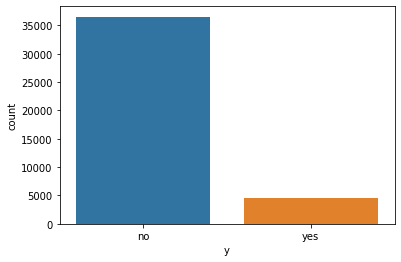

no     36548
yes     4640
Name: y, dtype: int64
Percentage of people who have taken the campaign: 11.265417111780131 %


In [263]:
# Plot Distribution
sns.countplot(x='y',data=bank_data)
plt.show()

# What are the counts?
print(bank_data.y.value_counts())

# What is the percentage?
count_yes = len(bank_data[bank_data.y == 'yes'])
count_no = len(bank_data[bank_data.y != 'yes'])

percent_success = (count_yes/(count_yes + count_no))*100

print('Percentage of people who have taken the campaign:', percent_success, "%")

### _Distribution of Other Variables_

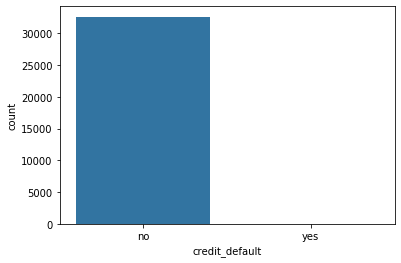

no     32588
yes        3
Name: credit_default, dtype: int64

In [264]:
sns.countplot(x="credit_default", data=bank_data)
plt.show()

bank_data.credit_default.value_counts()

In [265]:
## when someone is subscribing for the campaign, is it on a particular day of the week?
bank_data[bank_data.y == 'yes'].day_of_week.value_counts(normalize=True)*100

thu    22.521552
tue    20.538793
wed    20.452586
mon    18.254310
fri    18.232759
Name: day_of_week, dtype: float64

### _Drawing trends toward the target variable_

In [266]:
bank_data.groupby('y').mean()

,customer_no,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,,
no,19354.359719,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
yes,30362.742888,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


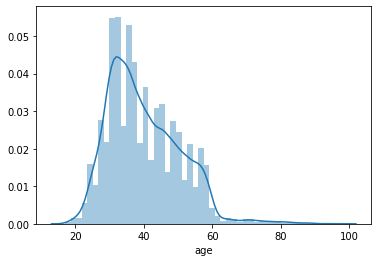

In [267]:
# Check distribution of age
%matplotlib inline
sns.distplot(bank_data["age"] )

In [268]:
# Does the kind of job matter to a subscription? (groupby job and aggregate by mean) 
# Extend to education, marital, etc.

bank_data.groupby(['job','y']).mean()

customer_no        age    duration  campaign       pdays  \
job           y                                                                
admin.        no   20442.671555  38.219846  215.093385  2.707718  981.270783   
              yes  31593.672337  37.968935  517.414201  2.058432  773.512574   
blue-collar   no   17463.693013  39.582057  229.878018  2.588208  991.516365   
              yes  24442.830721  39.200627  732.673981  2.156740  899.324451   
entrepreneur  no   18595.058559  41.703453  225.632883  2.579580  987.813814   
              yes  25937.862903  41.935484  667.540323  2.064516  910.943548   
housemaid     no   17192.181342  44.705451  218.778826  2.722222  986.491614   
              yes  31707.264151  52.650943  535.537736  1.896226  727.367925   
management    no   19867.435285  42.309707  220.828197  2.532357  984.848613   
              yes  30088.923780  42.783537  543.804878  2.030488  786.929878   
retired       no   23081.006221  59.926128  224.263608  2.657076  960.369362   
              yes  34996.403226  68.253456  420.235023  1.942396  712.937788   
self-employed no   19662.977201  40.176887  222.220912  2.724843  988.073113   
              yes  29785.093960  38.006711  622.020134  2.114094  878.859060   
services      no   18244.544158  38.090236  225.047998  2.619309  991.091607   
              yes  26681.931889  36.077399  634.851393  2.232198  854.479876   
student       no   28542.213333  26.396667  228.851667  2.238333  924.596667   
              yes  35871.487273  24.800000  403.316364  1.810909  656.116364   
technician    no   19682.693165  38.600033  213.452021  2.641776  985.135540   
              yes  30276.449315  37.746575  553.190411  2.046575  793.676712   
unemployed    no   19952.900000  39.844828  212.706897  2.668966  973.879310   
              yes  33586.687500  39.062500  471.451389  1.930556  702.333333   

                   previous  emp_var_rate  cons_price_idx  cons_conf_idx  \
job           y                                                            
admin.        no   0.141125      0.224068       93.566030     -40.349768   
              yes  0.510355     -1.383210       93.319537     -39.545488   
blue-collar   no   0.111653      0.303552       93.668887     -41.346565   
              yes  0.269592     -0.487774       93.491480     -41.770846   
entrepreneur  no   0.128378      0.242868       93.626245     -41.319820   
              yes  0.250000     -0.745161       93.381153     -40.895161   
housemaid     no   0.089099      0.641300       93.712759     -39.626834   
              yes  0.575472     -1.437736       93.350934     -38.311321   
management    no   0.140986      0.141217       93.550062     -40.619992   
              yes  0.533537     -1.230793       93.306631     -39.456402   
retired       no   0.212286     -0.283904       93.493273     -38.920762   
              yes  0.668203     -1.926267       93.245629     -37.542857   
self-employed no   0.123428      0.242610       93.591786     -40.501022   
              yes  0.315436     -1.173154       93.288470     -40.377852   
services      no   0.136314      0.256720       93.650433     -41.327537   
              yes  0.365325     -0.743034       93.456598     -40.866873   
student       no   0.395000     -1.133167       93.350790     -40.751500   
              yes  0.807273     -2.007636       93.289771     -38.957091   
technician    no   0.111093      0.441693       93.584196     -39.918310   
              yes  0.505479     -1.102055       93.374286     -40.003836   
unemployed    no   0.131034      0.147241       93.604369     -40.193908   
              yes  0.611111     -1.676389       93.318563     -38.881944   

                   euribor3m  nr_employed  
job           y                            
admin.        no    3.786567  5175.512051  
              yes   1.965078  5087.736760  
blue-collar   no    3.835402  5178.296031  
              yes   2.915715  5139.410658  
entreprene

In [269]:
# Who are subscribing the most across job ranks?
bank_data[bank_data.y == 'yes'].job.value_counts(normalize=True)*100

admin.           29.372149
technician       15.859222
blue-collar      13.860526
retired           9.428633
management        7.125788
services          7.017163
student           5.974365
self-employed     3.237019
unemployed        3.128395
entrepreneur      2.693895
housemaid         2.302846
Name: job, dtype: float64

### _Some Insights from the EDA done above_

* Number of Campaigns are lower for people who subscribed!

* People who subscribed for a term deposit are older (average age)

* customer_no attribute looks to be providing no value. Hence can be removed

* Few attributes such as job, marital, education, credit_default, housing, loan, contact, contacted_month, day_of_week, poutcome and y are categorical but are interpreted as object type. 

### _Feature Engineering_

#### _Fix levels of categorical variable by domain_

In [270]:
# Check levels of education. Is there anything wrong?
print(bank_data.education.value_counts())

# clean up basic level 
bank_data.replace(['basic.6y','basic.4y', 'basic.9y'], 'basic', inplace=True)
test_data.replace(['basic.6y','basic.4y', 'basic.9y'], 'basic', inplace=True)

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: education, dtype: int64


In [271]:
bank_data.education.value_counts()

basic                  12513
university.degree      12168
high.school             9515
professional.course     5243
illiterate                18
Name: education, dtype: int64

In [272]:
test_data.education.value_counts()

university.degree      1246
basic                  1239
high.school             948
professional.course     521
illiterate                1
Name: education, dtype: int64

#### _Drop unnecessary variables_ from both bank_data and test_data

In [273]:
bank_data.drop("customer_no", axis = 1, inplace= True)
test_data.drop("customer_no", axis = 1, inplace= True)

bank_data.head()

,age,job,marital,education,credit_default,housing,loan,contact,contacted_month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [274]:
print(bank_data.shape)
print(test_data.shape)

(41188, 21)
(4119, 21)


#### _Type Casting_

In [275]:
col = ['job', 'marital', 'education', 'credit_default', 'housing', 'loan', 'contact', 'contacted_month', 'day_of_week', 'poutcome', 'y']
bank_data[col] = bank_data[col].astype('category')

> How to choose between category and object:

reference : https://stackoverflow.com/questions/30601830/when-to-use-category-rather-than-object

The categorical data type is useful in the following cases:

* A string variable consisting of only a few different values. Converting such a string variable to a categorical variable will save some memory
* The lexical order of a variable is not the same as the logical order (“one”, “two”, “three”). By converting to a categorical and specifying an order on the categories, sorting and min/max will use the logical order instead of the lexical order
* As a signal to other Python libraries that this column should be treated as a categorical variable (e.g. to use suitable statistical methods or plot types).

In [276]:
bank_data.dtypes

age                   int64
job                category
marital            category
education          category
credit_default     category
housing            category
loan               category
contact            category
contacted_month    category
day_of_week        category
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome           category
emp_var_rate        float64
cons_price_idx      float64
cons_conf_idx       float64
euribor3m           float64
nr_employed         float64
y                  category
dtype: object

#### Split Numeric and Categorical Columns

In [277]:
cat_attr = list(bank_data.select_dtypes("category").columns)
num_attr = list(bank_data.columns.difference(cat_attr))

cat_attr.pop()

'y'

In [278]:
cat_attr

['job',
 'marital',
 'education',
 'credit_default',
 'housing',
 'loan',
 'contact',
 'contacted_month',
 'day_of_week',
 'poutcome']

In [279]:
num_attr

['age',
 'campaign',
 'cons_conf_idx',
 'cons_price_idx',
 'duration',
 'emp_var_rate',
 'euribor3m',
 'nr_employed',
 'pdays',
 'previous']

#### _Handle Missing Values_

In [280]:
bank_data.isnull().sum()

age                   0
job                 330
marital              80
education          1731
credit_default     8597
housing             990
loan                990
contact               0
contacted_month       0
day_of_week           0
duration              0
campaign              0
pdays                 0
previous              0
poutcome              0
emp_var_rate          0
cons_price_idx        0
cons_conf_idx         0
euribor3m             0
nr_employed           0
y                     0
dtype: int64

In [281]:
# print total number of missing values
bank_data.isnull().sum().sum()

12718

## Sklearn pipelines

Pipelines are a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling instead just writing a bunch of code.

Pipelines are set up with the fit/transform/predict functionality, so you can fit a whole pipeline to the training data and transform to the test data, without having to do it individually for each thing you do. Super convenient, right?

Steps to follow to create a pipeline:

Step 1) Fetch the numerical and categorical columns

Step 2) Create a transformer/pipeline for numerical attributes

    Create a list of tuples where each tuple represents the operation to be performed on numerical attributes

Step 3) Create a transformer/pipeline for categorical attributes

    Create a list of tuples where each tuple represent the operation to be performed on categorical attributes

Step 4) Create a ColumnTransformer which merges both the numerical and categorical transformers

Step 5) Create a final pipeline object which includes the ColumnTransformer and an estimator (an algorithm to be build on dataset)

Step 6) (optional) Create a GridSearchCV object with pipeline as one of the inputs along with hyperparameter grid and Cross validation object

Step 7) Apply fit() on train data and predict() on test data <br><br>

**TL; DR**
Pipeline is a collection of transformers chained together and operate sequentially. (often ending with an estimator)

__Bird's view of sklearn pipeline__

<img src="./images/Pipeline_broadview.png"><br><br>

__Train and Test dataflow inside the sklearn pipeline__
<img src="./images/fit_tranform.jpg">

#### _Instantiate Pre-processing Objects for Pipeline_

In [282]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

In [283]:
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [284]:
numeric_transformer.named_steps

{'imputer': SimpleImputer(strategy='median'), 'scaler': StandardScaler()}

In [285]:
numeric_transformer.named_steps.scaler

StandardScaler()

In [286]:
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [287]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'campaign', 'cons_conf_idx',
                                  'cons_price_idx', 'duration', 'emp_var_rate',
                                  'euribor3m', 'nr_employed', 'pdays',
                                  'previous']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education',
                                  'credit_default', '

In [288]:
type(preprocessor)

sklearn.compose._column_transformer.ColumnTransformer

### _Train-Test Split_

In [289]:
X_train, y_train = bank_data.loc[:,bank_data.columns!='y'], bank_data.loc[:,'y']

X_test, y_test = test_data.loc[:,test_data.columns!='y'], test_data.loc[:,'y']

In [137]:
X_train.head()

,age,job,marital,education,credit_default,housing,loan,contact,contacted_month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [138]:
y_train.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: category
Categories (2, object): [no, yes]

#### _Instantiate Pipeline Object_

In [139]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

###  _Build Logistic Regression Model - 1_

In [140]:
%%time
clf_logreg.fit(X_train, y_train)

CPU times: user 10.2 s, sys: 205 ms, total: 10.4 s
Wall time: 7.15 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign',
                                                   'cons_conf_idx',
                                                   'cons_price_idx', 'duration',
                                                   'emp_var_rate', 'euribor3m',
                                                   'nr_employed', 'pdays',
                                                   'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('i

### _Evaluate Model_

In [142]:
train_pred = clf_logreg.predict(X_train)
test_pred = clf_logreg.predict(X_test)

print(clf_logreg.score(X_train, y_train))
print(clf_logreg.score(X_test, y_test))
print("\n")
print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)
confusion_matrix_test

0.9113091191609206
0.9099295945617868


[[35567   981]
 [ 2672  1968]]


array([[3560,   97],
       [ 274,  188]])

In [143]:
print(classification_report(y_true=y_test, y_pred =  test_pred))

              precision    recall  f1-score   support

          no       0.93      0.97      0.95      3657
         yes       0.66      0.41      0.50       462

    accuracy                           0.91      4119
   macro avg       0.79      0.69      0.73      4119
weighted avg       0.90      0.91      0.90      4119



In [144]:
Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Test Accuracy: ",Accuracy_test)

Test Precision:  0.6596491228070176
Test Recall:  0.4069264069264069
Test Accuracy:  0.9099295945617868


#### Using the function to calculate accuracy, precision and recall.

In [145]:
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.6596491228070176
Test Recall:  0.4069264069264069
Test Accuracy:  0.9099295945617868


### _Build Decision Tree Model - 2_

In [146]:
%%time
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5,verbose=3)

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2, score=0.891, total=   4.8s
[CV] classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV]  classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2, score=0.717, total=   4.6s
[CV] classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


[CV]  classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2, score=0.852, total=   4.6s
[CV] classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2 
[CV]  classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2, score=0.145, total=   4.6s
[CV] classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2 
[CV]  classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=2, score=0.142, total=   4.6s
[CV] classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=10 
[CV]  classifier__criterion=entropy, classifier__max_depth=6, classifier__min_samples_leaf=1, classifier__min_samples_split=10, score=0.891, total=   4.6s
[CV]

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 28.0min finished


CPU times: user 27min 55s, sys: 8.83 s, total: 28min 3s
Wall time: 28min 4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',
                                                          

In [147]:
dt_grid.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 10}

In [148]:
train_pred = dt_grid.predict(X_train)
test_pred = dt_grid.predict(X_test)

print(dt_grid.score(X_train, y_train))
print(dt_grid.score(X_test, y_test))

0.9180586578615131
0.9210973537266327


In [149]:
print(classification_report(y_true=y_test, y_pred =  test_pred))

              precision    recall  f1-score   support

          no       0.94      0.97      0.96      3657
         yes       0.71      0.50      0.59       462

    accuracy                           0.92      4119
   macro avg       0.83      0.74      0.77      4119
weighted avg       0.91      0.92      0.91      4119



In [150]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.7120743034055728
Test Recall:  0.49783549783549785
Test Accuracy:  0.9210973537266327


###  _Build Random Forest Model - 3_ (Using Stratified KFold)

__Stratified K-Folds cross-validator__

This cross-validation object is a **variation** of KFold that returns stratified folds. The folds are made by **preserving the percentage of samples for each class**.

In [151]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [156]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

param_grid = {"classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [5,8,10],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8, 10]}

rf_grid = GridSearchCV(clf, param_grid= param_grid, cv=kfold,verbose=1,n_jobs=6)

In [157]:
rf_grid

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',


In [158]:
%%time
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 540 out of 540 | elapsed: 14.6min finished


CPU times: user 18.8 s, sys: 340 ms, total: 19.1 s
Wall time: 14min 49s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',


In [159]:
rf_grid.best_params_

{'classifier__max_depth': 10,
 'classifier__max_features': 7,
 'classifier__min_samples_leaf': 4,
 'classifier__n_estimators': 250}

In [160]:
train_pred = rf_grid.predict(X_train)
test_pred = rf_grid.predict(X_test)

print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

0.9206079440613771
0.9167273610099539
Test Precision:  0.8115183246073299
Test Recall:  0.3354978354978355
Test Accuracy:  0.9167273610099539


### _Build Gradient Boosting - 4_

In [161]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('GBM',GradientBoostingClassifier())])

In [162]:
%%time
gbm_param_grid = {'GBM__max_depth': [8,10,12,14], 'GBM__subsample': [0.8, 0.6,], 'GBM__max_features':[0.2, 0.3], 
              'GBM__n_estimators': [10, 20, 30]}

gbm_grid = GridSearchCV(clf, param_grid=gbm_param_grid, cv=3,n_jobs=6)

gbm_grid.fit(X_train,y_train)

CPU times: user 9.02 s, sys: 84 ms, total: 9.11 s
Wall time: 2min 50s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',
                                                          

In [163]:
gbm_grid.best_params_

{'GBM__max_depth': 8,
 'GBM__max_features': 0.2,
 'GBM__n_estimators': 10,
 'GBM__subsample': 0.8}

In [164]:
train_pred = gbm_grid.predict(X_train)
test_pred = gbm_grid.predict(X_test)

print(gbm_grid.score(X_train, y_train))
print(gbm_grid.score(X_test, y_test))

# Using the function to calcula`te accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

0.912425949305623
0.9116290361738286
Test Precision:  0.9375
Test Recall:  0.22727272727272727
Test Accuracy:  0.9116290361738286


### _Build SVM - 5_

In [165]:
%%time
clf_svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

svm_param_grid = {'classifier__C': [50,90], 'classifier__gamma': [0.008, 0.001],
                 "classifier__kernel": ['rbf']}

svm_grid = GridSearchCV(clf_svm, param_grid= svm_param_grid, cv= 5,n_jobs=6)

svm_grid.fit(X_train,y_train)

CPU times: user 41.9 s, sys: 224 ms, total: 42.1 s
Wall time: 3min 24s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',
                                                          

In [166]:
svm_grid.best_params_

{'classifier__C': 50, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}

In [167]:
train_pred = svm_grid.predict(X_train)
test_pred = svm_grid.predict(X_test)

print(svm_grid.score(X_train, y_train))
print(svm_grid.score(X_test, y_test))

print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)

0.9097067106924347
0.9082301529497451
[[35854   694]
 [ 3025  1615]]


In [168]:
Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Train Accuracy: ",Accuracy_test)

Test Precision:  0.6909090909090909
Test Recall:  0.329004329004329
Train Accuracy:  0.9082301529497451


## _Handling Imbalanced Data_

### _1. Class Weights of loss function_

In [169]:
%%time
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10],
                 "classifier__class_weight":['balanced']}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5, n_jobs=6)
dt_grid_bal.fit(X_train,y_train)

CPU times: user 11.4 s, sys: 216 ms, total: 11.6 s
Wall time: 7min 47s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',
                                                          

In [170]:
train_pred = dt_grid_bal.predict(X_train)
test_pred = dt_grid_bal.predict(X_test)

print(dt_grid_bal.score(X_train, y_train))
print(dt_grid_bal.score(X_test, y_test))

# Using the function to calculate accuracy, precision and recall.
# accuracy_precision_recall_metrics(y_true = y_train, y_pred= train_pred)
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

0.8636253277653686
0.8691429958727847
Test Precision:  0.45951629863301785
Test Recall:  0.9458874458874459
Test Accuracy:  0.8691429958727847


### _2. Oversample Using SMOTE_

<img src="./images/SMOTE.jpg" width = '600'><br>

In [290]:
clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_pp = pd.DataFrame(clf.fit_transform(X_train))
X_test_pp = pd.DataFrame(clf.transform(X_test))

In [291]:
smote = SMOTE(random_state=0)

os_data_X,os_data_y=smote.fit_sample(X_train_pp, y_train)

os_data_X = pd.DataFrame(data=os_data_X)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']=='no']))
print("Number of subscription",len(os_data_y[os_data_y['y']=='yes']))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='no'])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='yes'])/len(os_data_X))

length of oversampled data is  73096
Number of no subscription in oversampled data 36548
Number of subscription 36548
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [292]:
%%time
clf_dt = Pipeline(steps=[('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5, n_jobs=-1)

dt_grid_bal.fit(os_data_X,os_data_y)

CPU times: user 2.22 s, sys: 352 ms, total: 2.58 s
Wall time: 27.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_depth': [6, 8, 10, 12],
                         'classifier__min_samples_leaf': [1, 5, 10],
                         'classifier__min_samples_split': [2, 10, 20]})

In [303]:
train_pred = dt_grid_bal.predict(os_data_X)
test_pred = dt_grid_bal.predict(X_test_pp)

print(dt_grid_bal.score(os_data_X, os_data_y))
print(dt_grid_bal.score(X_test_pp, y_test))

confusion_matrix_train = confusion_matrix(y_true=os_data_y, y_pred = train_pred)
print("\n",confusion_matrix_train2)

Accuracy_train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(np.sum(confusion_matrix_train))

Precision_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,1]+confusion_matrix_train[0,1])
Recall_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
print("\n")
print("Train Precision: ",Precision_Train)
print("Train Recall: ",Recall_Train)
print("Train Accuracy: ",Accuracy_train)

0.9161924045091386
0.8858946346200534

 [[32360  4188]
 [ 1938 34610]]


Train Precision:  0.8920562915614207
Train Recall:  0.9469738426179272
Train Accuracy:  0.9161924045091386


In [298]:
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.4951338199513382
Test Recall:  0.8809523809523809
Test Accuracy:  0.8858946346200534


# Random Forest to obtain important features.

In [178]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [179]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

param_grid = {"classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [5,8,10],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8, 10]}

rf_grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold)

In [180]:
%%time
rf_grid.fit(X_train,y_train)

CPU times: user 19.7 s, sys: 252 ms, total: 20 s
Wall time: 14min 44s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',


In [181]:
rf_grid.best_params_

{'classifier__max_depth': 10,
 'classifier__max_features': 7,
 'classifier__min_samples_leaf': 4,
 'classifier__n_estimators': 300}

In [182]:
pl = rf_grid.best_estimator_.named_steps['preprocessor']
catpl = pl.named_transformers_['cat']
ohe = catpl.named_steps['onehot']
ohe_features = ohe.get_feature_names()
print(ohe_features)

['x0_admin.' 'x0_blue-collar' 'x0_entrepreneur' 'x0_housemaid'
 'x0_management' 'x0_retired' 'x0_self-employed' 'x0_services'
 'x0_student' 'x0_technician' 'x0_unemployed' 'x1_divorced' 'x1_married'
 'x1_single' 'x2_basic' 'x2_high.school' 'x2_illiterate'
 'x2_professional.course' 'x2_university.degree' 'x3_no' 'x3_yes' 'x4_no'
 'x4_yes' 'x5_no' 'x5_yes' 'x6_cellular' 'x6_telephone' 'x7_apr' 'x7_aug'
 'x7_dec' 'x7_jul' 'x7_jun' 'x7_mar' 'x7_may' 'x7_nov' 'x7_oct' 'x7_sep'
 'x8_fri' 'x8_mon' 'x8_thu' 'x8_tue' 'x8_wed' 'x9_failure'
 'x9_nonexistent' 'x9_success']


In [183]:
num_attr.extend(ohe_features)

['age',
 'campaign',
 'cons_conf_idx',
 'cons_price_idx',
 'duration',
 'emp_var_rate',
 'euribor3m',
 'nr_employed',
 'pdays',
 'previous',
 'x0_admin.',
 'x0_blue-collar',
 'x0_entrepreneur',
 'x0_housemaid',
 'x0_management',
 'x0_retired',
 'x0_self-employed',
 'x0_services',
 'x0_student',
 'x0_technician',
 'x0_unemployed',
 'x1_divorced',
 'x1_married',
 'x1_single',
 'x2_basic',
 'x2_high.school',
 'x2_illiterate',
 'x2_professional.course',
 'x2_university.degree',
 'x3_no',
 'x3_yes',
 'x4_no',
 'x4_yes',
 'x5_no',
 'x5_yes',
 'x6_cellular',
 'x6_telephone',
 'x7_apr',
 'x7_aug',
 'x7_dec',
 'x7_jul',
 'x7_jun',
 'x7_mar',
 'x7_may',
 'x7_nov',
 'x7_oct',
 'x7_sep',
 'x8_fri',
 'x8_mon',
 'x8_thu',
 'x8_tue',
 'x8_wed',
 'x9_failure',
 'x9_nonexistent',
 'x9_success']

In [184]:
feature_imp = rf_grid.best_estimator_.steps[1][1].feature_importances_
print(feature_imp)

[2.51734157e-02 9.06980656e-03 4.40435048e-02 3.41473842e-02
 3.48716616e-01 4.54751403e-02 1.29136606e-01 1.04149507e-01
 6.45645794e-02 1.47835372e-02 2.60726226e-03 2.48446175e-03
 5.32872083e-04 5.92201650e-04 1.08660057e-03 2.75666096e-03
 8.89462729e-04 1.03804835e-03 1.86400723e-03 2.12919995e-03
 5.60311227e-04 1.45638529e-03 2.71304454e-03 2.75576038e-03
 2.86807510e-03 2.25759453e-03 1.30676236e-05 1.83349574e-03
 3.44355375e-03 0.00000000e+00 0.00000000e+00 2.76936202e-03
 2.72290964e-03 1.93555501e-03 1.76187130e-03 7.65627607e-03
 7.23709479e-03 5.83300215e-03 1.80621457e-03 6.16460164e-04
 1.37394746e-03 2.62985777e-03 9.82473067e-03 7.34103548e-03
 1.52387751e-03 9.43829046e-03 1.97991102e-03 2.64256420e-03
 4.47251068e-03 3.05248831e-03 2.90207620e-03 2.53966738e-03
 8.46100987e-03 1.11890441e-02 4.51480798e-02]


In [185]:
feature_imp_df = pd.DataFrame(feature_imp.tolist(),index =num_attr,columns=['var_imp'])
feature_imp_df = feature_imp_df.sort_values(by="var_imp",ascending=False)
feature_imp_df.head(8)

,var_imp
duration,0.348717
euribor3m,0.129137
nr_employed,0.104150
pdays,0.064565
emp_var_rate,0.045475
x9_success,0.045148
cons_conf_idx,0.044044
cons_price_idx,0.034147


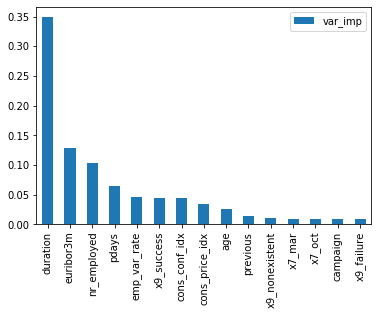

In [186]:
feature_imp_df[:15].plot(kind='bar')

In [187]:
train_pred = rf_grid.predict(X_train)
test_pred = rf_grid.predict(X_test)

print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

0.9211178013013499
0.9172129157562515
Test Precision:  0.7980295566502463
Test Recall:  0.35064935064935066
Test Accuracy:  0.9172129157562515


# Random Forest -2

In [203]:
%%time

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

param_grid = {"classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [5,8,10],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8, 10],
             "classifier__class_weight":["balanced"]}

rf_grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold,verbose=2)


rf_grid.fit(X_train,y_train)

rf_grid.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 12.6min finished


CPU times: user 17 s, sys: 329 ms, total: 17.3 s
Wall time: 12min 44s


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 10,
 'classifier__max_features': 7,
 'classifier__min_samples_leaf': 4,
 'classifier__n_estimators': 150}

In [204]:
train_pred = rf_grid.predict(X_train)
test_pred = rf_grid.predict(X_test)

print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

0.8677770224337186
0.871327992231124
Test Precision:  0.46405919661733613
Test Recall:  0.9502164502164502
Test Accuracy:  0.871327992231124


# Interesting links:

https://scikit-learn.org/stable/

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html